# Section 1: Homework Exercises

This material provides some hands-on experience using the methods learned from the first day's material. They focus on building models using real-world data.

In [8]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
import warnings
warnings.simplefilter("ignore")

import pymc3 as pm
import arviz as az

## Exercise: Comparing Two Groups with Binary Outcomes

Binary outcomes are common in clinical research: 

- survival/death
- true/false
- presence/absence
- positive/negative

In practice, binary outcomes are encoded as ones (for event occurrences) and zeros (for non-occurrence). A single binary variable is distributed as a **Bernoulli** random variable:

$$f(x \mid p) = p^{x} (1-p)^{1-x}$$

In terms of inference, we are typically interested in whether $p$ is larger or smaller in one group relative to another.

To demonstrate the comparison of two groups with binary outcomes using Bayesian inference, we will use a sample pediatric dataset. Data on 671 infants with very low (<1600 grams) birth weight from 1981-87 were collected at Duke University Medical Center. Of interest is the relationship between the outcome intra-ventricular hemorrhage (IVH) and predictor such as birth weight, gestational age, presence of pneumothorax and mode of delivery.

In [2]:
vlbw = pd.read_csv('../data/vlbw.csv', index_col=0).dropna(axis=0, subset=['ivh', 'pneumo'])
vlbw.head()

,birth,exit,hospstay,lowph,pltct,race,bwt,gest,inout,twn,...,vent,pneumo,pda,cld,pvh,ivh,ipe,year,sex,dead
5,81.593002,81.598999,2.0,6.969997,54.0,black,925.0,28.0,born at Duke,0.0,...,1.0,1.0,0.0,0.0,definite,definite,NaN,81.594055,female,1
6,81.601997,81.771004,62.0,7.189999,NaN,white,940.0,28.0,born at Duke,0.0,...,1.0,0.0,0.0,0.0,absent,absent,absent,81.602295,female,0
13,81.683998,81.853996,62.0,7.179996,182.0,black,1110.0,28.0,born at Duke,0.0,...,0.0,1.0,0.0,1.0,absent,absent,absent,81.684448,male,0
14,81.689003,81.877998,69.0,7.419998,361.0,white,1180.0,28.0,born at Duke,0.0,...,0.0,0.0,0.0,0.0,absent,absent,absent,81.689880,male,0
16,81.696999,81.952004,93.0,7.239998,255.0,black,770.0,26.0,born at Duke,0.0,...,1.0,0.0,0.0,1.0,absent,absent,absent,81.698120,male,0


To demonstrate binary data analysis, we will try to estimate the difference between the probability of an intra-ventricular hemorrhage for infants with and without a pneumothorax. 

In [3]:
pd.crosstab(vlbw.ivh, vlbw.pneumo)

pneumo,0.0,1.0
ivh,,
absent,359,73
definite,45,30
possible,6,4


We will create a binary outcome by combining `definite` and `possible` into a single outcome.

In [4]:
ivh = vlbw.ivh.isin(['definite', 'possible']).astype(int).values
x = vlbw.pneumo.astype(int).values

Fit a model that evaluates the association of a pneumothorax with the presence of IVH.

In [6]:
with pm.Model() as ivh_model:
    
    p = pm.Beta('p', 1, 1, shape=2)
    
    bb_like = pm.Bernoulli('bb_like', p=p[x], observed=ivh)
    
    p_diff = pm.Deterministic('p_diff', p[1] - p[0])
    
    ivh_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


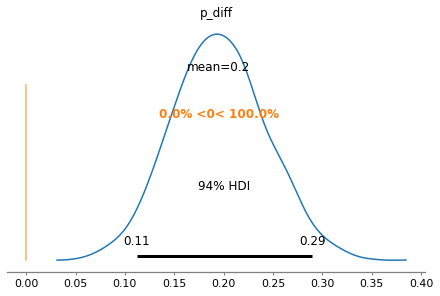

In [10]:
az.plot_posterior(ivh_trace, var_names=['p_diff'], ref_val=0);

## Exercise: Cancer Rate Estimation

[Tsutakawa et al. (1985)](http://onlinelibrary.wiley.com/doi/10.1002/sim.4780040210/abstract) provides mortality data for stomach cancer among men aged 45-64 in several cities in Missouri. The file `cancer.csv` contains deaths $y_i$ and subjects at risk $n_i$ for 20 cities from this dataset.

In [8]:
import pandas as pd

cancer = pd.read_csv('../data/cancer.csv')
cancer

,y,n
0,0,1083
1,0,855
2,2,3461
3,0,657
4,1,1208
5,1,1025
6,0,527
7,2,1668
8,1,583
9,3,582


If we use a simple binomial model, which assumes independent samples from a binomial distribution with probability of mortality $p$, we can use MLE to obtain an estimate of this probability.

$$\hat{p} = \frac{y}{n}$$

In [16]:
p_hat = cancer.y.sum() / cancer.n.sum()
p_hat

0.0009933126276616582

The binomial variance can be caclulated by:

$$\text{Var}(y) = np(1-p)$$

In [71]:
mle_var = (cancer.n * p_hat * (1-p_hat)).sum()
mle_var

70.92947480343602

However, if we compare this to the observed variance in $y$, things don't look good.

In [17]:
cancer.y.var()

141.94473684210527

In [73]:
_p = trace['p'].mean(axis=0)

In [74]:
(cancer.n * _p * (1-_p)).sum()

73.87802701341326

However, if we compare this to the observed variance in $y$, things don't look good. The data are *overdispersed* relative to what would be expected from a binomial model. As you might expect, it is unrealistic to assume the prevalence of cancer to be the same in all cities. Rather, a more realistic model might allow the probability to vary from place to place, according to any number of unmeasured risk factors. 

Create a hierarchical model that allows the cancer prevalence to vary. 

*Hint: a reasonable distribution for probabilities is the beta distribution. So, you would want to estimate the hyperparameters of the beta distribution to fit the hierarchical model.*

In [44]:
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

In [65]:
with pm.Model() as hierarchical_model:
    
    # Prior on p
    a = pm.Exponential('a', 0.5)
    b = pm.Exponential('b', 0.5)
    p = pm.Beta('p', a, b, shape=cancer.y.shape[0])
    
    # Likelihood function
    deaths = pm.Binomial('deaths', n=cancer.n.values, p=p, observed=cancer.y.values)

In [66]:
with hierarchical_model:
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8807516035482813, but should be close to 0.8. Try to increase the number of tuning steps.
There were 570 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6535189303747259, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/fonnesbeck/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7e2a460428d0>],
      dtype=object)

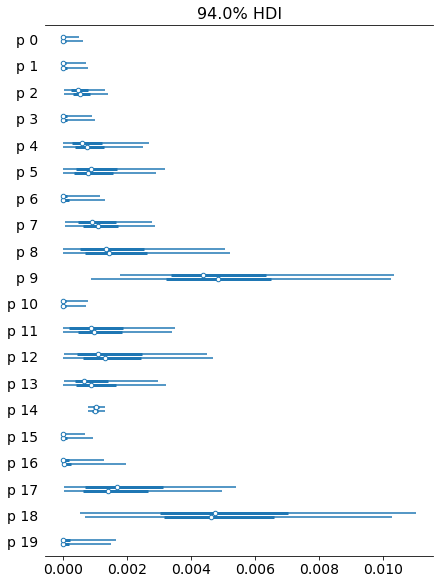

In [67]:
az.plot_forest(trace, var_names=['p'])